# Question 4: k-means
"Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. Please find the data set here https://www.kaggle.com/ hellbuoy/online-retail-customer-clustering. Use the k−means algorithm to find the best set of customers which the company should target. Please discuss your modeling strategy and parametric choices."

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

from sklearn.cluster import KMeans

## Preprocessing

First we'll process the data and print out some statstics about the dataset. Note that we're going to drop any rows where the "Customer ID" is NaN, i.e. there is a missing value.

In [32]:
parse_date = lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M')

data = pd.read_csv("OnlineRetail.csv", parse_dates = ["InvoiceDate"], \
                   date_parser = parse_date, encoding = "ISO-8859-1")
date_col = data["InvoiceDate"]

print("Latest Date: ", max(date_col))
print("Oldest Date: ", min(date_col))

data = data[data["CustomerID"].notna()]

# Get uniquer customer identifiers:
customer_ids = data["CustomerID"].unique() # Ordering preserved in list

print("Number of customers =", len(customer_ids))

Latest Date:  2011-12-09 12:50:00
Oldest Date:  2010-12-01 08:26:00
Number of customers = 4372


Now let's visualize when customers bought items from this company, just to get an idea of our dataset:

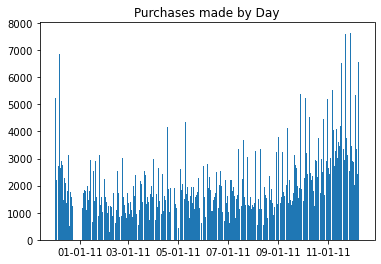

In [33]:
# Get unique dates and frequencies:
str_dates = ["{:02d}-{:02d}-{}".format(d.month, d.day, d.year) for d in date_col]

mdates_list = mdates.datestr2num(str_dates)

fig, ax = plt.subplots(1, 1)
ax.hist(mdates_list, bins = len(set(str_dates)))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d-%y'))
plt.title("Purchases made by Day")
plt.show()

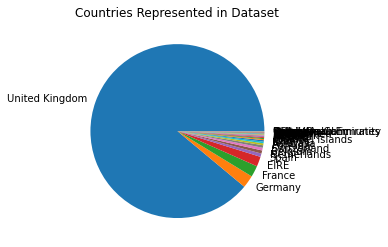

In [34]:
# Get the countries in the dataset
countries = data['Country'].value_counts()
c_list = list(countries.index)
values = list(countries[:])

plt.pie(values, labels = c_list)
plt.title("Countries Represented in Dataset")
plt.show()

It is very difficult to see the countries on the right, but the important point here is that most customers are from the UK while around 1/6 of all of the customers are from a variety of other countries.

## RFM Breakdown

Now we need to build an "RFM" analysis (Recency, Frequency, Monetary), i.e. we want to determine how recent the customers bought from the company, how often they bought, and how much money they spent. From these numbers, we will create a clustering model, and then we will determine the characteristic features of these clusters such as country of residence and types of products bought.

In [35]:
# Build recency data: 

# Using the newest (maximum) date as a reference:
newest_date = max(data["InvoiceDate"])
customer_rec = [(newest_date - (data["InvoiceDate"][data["CustomerID"] == cid]).max()).total_seconds() \
                for cid in customer_ids]

# Build frequency data:
customer_freq  = data["CustomerID"].value_counts()

customer_freq  = [customer_freq[cid] for cid in customer_ids] # Build list

# Build monetary data:
customer_mon = [(data["UnitPrice"][data["CustomerID"] == cid]).sum() for cid in customer_ids]

Now I'll just put all of the data together so that we can work with it easier for the analysis.

In [36]:
# Build entire dataframe:
customer_data = {'R':customer_rec, 'F':customer_freq, 'M':customer_mon}
customer_data = pd.DataFrame(customer_data, columns = ['R','F','M'])

print(customer_data)

               R    F        M
0     26086320.0  312  1224.51
1      2680800.0  196   798.30
2       189780.0  251   791.28
3      8219100.0   28   111.90
4     28496460.0    6    65.70
...          ...  ...      ...
4367     94620.0   12    69.96
4368     93120.0   18    31.04
4369     85140.0    2     7.50
4370     78720.0   12    47.04
4371      2040.0   38    95.13

[4372 rows x 3 columns]


Before we use the k-means algorithm, I will normalize the data. This removes the effects of differing units for the R, F, and M categories. For example, you can see that the timescale in the dataframe above is much larger than the monetary quantity on average; we wouldn't want this difference in units to affect the clustering by causing the algorithm to heavily weigh recency. Normalization takes away this effect. 

I print the normalized columns, in addition to the regular columns printed above, below this block of code for a visual of how normalization standardizes the units.

In [37]:
# Now normalize all of the data for use in clustering:
classes = ['R', 'F', 'M']

col_means = {c: np.mean(customer_data[c]) for c in classes}
col_std   = {c: np.std(customer_data[c]) for c in classes}

for i in classes:
    customer_data[i] = (customer_data[i] - col_means[i]) / col_std[i]
    
print(customer_data)

             R         F         M
0     2.087717  0.941929  0.702535
1    -0.600839  0.442886  0.370760
2    -0.886979  0.679501  0.365295
3     0.035337 -0.279865 -0.163555
4     2.364566 -0.374511 -0.199518
...        ...       ...       ...
4367 -0.897910 -0.348699 -0.196202
4368 -0.898082 -0.322886 -0.226499
4369 -0.898999 -0.391720 -0.244823
4370 -0.899736 -0.348699 -0.214044
4371 -0.908544 -0.236844 -0.176609

[4372 rows x 3 columns]


## k-means Clustering
Now we will fit k-means clustering algorithm to the data. This clustering algorithm works by minimizing the distance from sample points to a certain number (k) of cluster centers, finding the optimal cluster centers that achieve this goal. i.e. k-means minimizes the cost function:

$$f(x) = \sum_{j = 1}^{N} ||c_i - a_j ||^2 $$

where $c_i$ is some centroid in the graph and $a_j$ is each data point in the graph.

We will take a variety of cluster numbers (k values), and then we will take the scores of k-means to analyze how well the k value works:

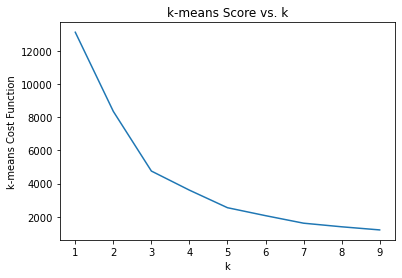

In [38]:
k_tries = range(1, 10)

k_score = []

for k in k_tries:
    model = KMeans(n_clusters = k)
    model.fit(customer_data.to_numpy())
    k_score.append(model.inertia_)
    
plt.plot(k_tries, k_score)
plt.title("k-means Score vs. k")
plt.xlabel("k")
plt.ylabel("k-means Cost Function")
plt.show()

Since the elbow point occurs around k = 3, but we will choose k = 5 for our model hyperparameter so that we can be sure to capture as many distinct froups as will still benefit us.

In [39]:
final_model = KMeans(n_clusters = 5)
final_model.fit(customer_data.to_numpy())
predictions = list(final_model.predict(customer_data.to_numpy()))

In [40]:
customer_data['cluster'] = predictions
print(customer_data)

             R         F         M  cluster
0     2.087717  0.941929  0.702535        0
1    -0.600839  0.442886  0.370760        1
2    -0.886979  0.679501  0.365295        1
3     0.035337 -0.279865 -0.163555        1
4     2.364566 -0.374511 -0.199518        0
...        ...       ...       ...      ...
4367 -0.897910 -0.348699 -0.196202        1
4368 -0.898082 -0.322886 -0.226499        1
4369 -0.898999 -0.391720 -0.244823        1
4370 -0.899736 -0.348699 -0.214044        1
4371 -0.908544 -0.236844 -0.176609        1

[4372 rows x 4 columns]


Now we will plot the clusters in the 3d space to visualize them:

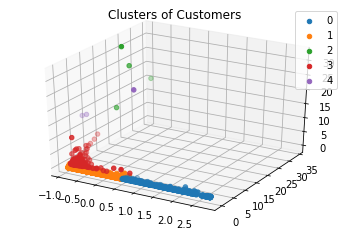

In [41]:
groups = customer_data.groupby('cluster')

ax = plt.axes(projection = '3d')

for name, group in groups:
    ax.scatter3D(group['R'], group['F'], group['M'], label = name)
    
plt.legend()
plt.title("Clusters of Customers")
plt.show()

Now we want to print out some statistics for each of the clusters:

Cluster number 0
Size = 	 1065
Mean R = 	 1.569895100425431
Mean F = 	 -0.2810448343662463
Mean M = 	 -0.17318745266406416
Cluster number 1
Size = 	 3032
Mean R = 	 -0.48269191891422314
Mean F = 	 -0.09058031349141718
Mean M = 	 -0.07758317143290419
Cluster number 2
Size = 	 4
Mean R = 	 -0.8945431020545836
Mean F = 	 25.04225175979913
Mean M = 	 20.744733159997068
Cluster number 3
Size = 	 268
Mean R = 	 -0.7641862167244493
Mean F = 	 1.7641744801648769
Mean M = 	 0.9991834481553972
Cluster number 4
Size = 	 3
Mean R = 	 -0.012101771594193825
Mean F = 	 0.32816379421525643
Mean M = 	 22.972238708720592


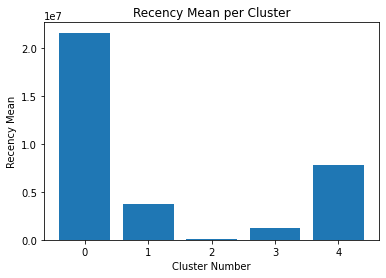

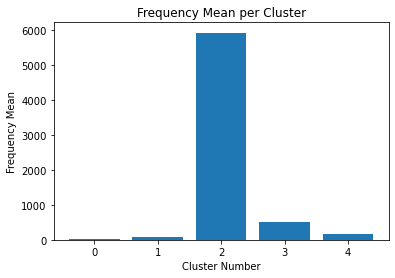

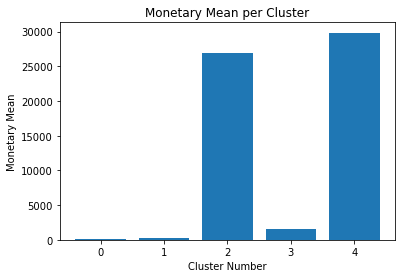

In [42]:
rmean = []
fmean = []
mmean = []

for name, group in groups:
    print("Cluster number {}".format(name))
    print("Size = \t", group.shape[0])
    print("Mean R = \t", np.mean(group['R']))
    print("Mean F = \t", np.mean(group['F']))
    print("Mean M = \t", np.mean(group['M']))
    rmean.append(np.mean(group['R']) * col_std['R'] + col_means['R'])
    fmean.append(np.mean(group['F']) * col_std['F'] + col_means['F'])
    mmean.append(np.mean(group['M']) * col_std['M'] + col_means['M'])
    
fig, ax = plt.subplots()
ax.bar(range(0, 5), rmean)
ax.set_title("Recency Mean per Cluster")
plt.ylabel("Recency Mean")
plt.xlabel("Cluster Number")
plt.show()

fig, ax = plt.subplots()
ax.bar(range(0, 5), fmean)
ax.set_title("Frequency Mean per Cluster")
plt.ylabel("Frequency Mean")
plt.xlabel("Cluster Number")
plt.show()

fig, ax = plt.subplots()
ax.bar(range(0, 5), mmean)
ax.set_title("Monetary Mean per Cluster")
plt.ylabel("Monetary Mean")
plt.xlabel("Cluster Number")
plt.show()

Two of the clusters are very small and represent outliers in our data. However, the other three are made up of large numbers of customers. Of these three large clusters, Cluster 3 seems very interesting. It has higher F and M values while having a lower R value than the other two large clusters, all desirable qualities in a customer. 

This group of customers identified in cluster 3 would be the best to target for advertising for this company. Their purchases resulted in a higher mean amount of money spent, and these customers seem to be coming into the store recently. Further data would be needed on these customers in order to understand how to target the adversiting towards this group of people. 

## Analysis of Home Countries

I hypothesized that these clusters would share common home countries, but that hypothesis unfortunately did not hold. I have included my analysis of the countries of each of these clusters below:

In [43]:
# Link the clusters (by CustomerID) back to the original dataframe
original_df_col = []

cluster_ids = customer_data['cluster']
cid_list = list(customer_ids)

for i in range(0, data.shape[0]):
# Find all instances of each customer ID in original dataframe, 
#  set equal to that customer's cluster ID
    cid = data['CustomerID'].iloc[i]
    original_df_col.append(cluster_ids.iloc[cid_list.index(cid)])
    
data['cluster'] = original_df_col

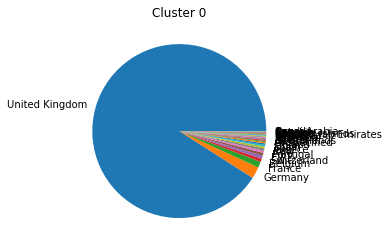

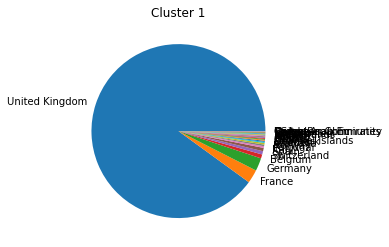

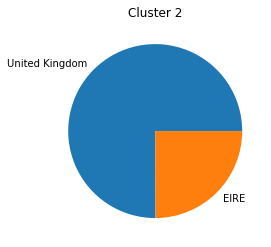

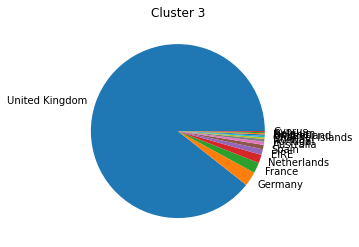

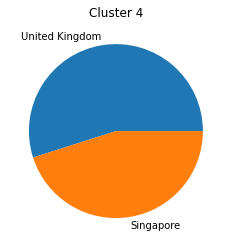

In [44]:
# Get countries, products bought in clusters
cluster_inds = range(0, 5)

# Get countries:
countries = []

for c in cluster_inds:
    countries.append(data[data["cluster"] == c]["Country"].value_counts())
    plt.pie(countries[c][:], labels = list(countries[c].index))
    plt.title("Cluster {}".format(c))
    plt.show()


The majority of these customers are from the UK, and more detailed data collection could provide further insights into the origins of these customers.